In [1]:
# Reloads the python files outside of this notebook automatically
%load_ext autoreload
%autoreload 2

# import all Python modules
from distutils.util import strtobool
from functools import partial
from IPython.display import display, HTML  # For animations in the notebook
from jax import config as jax_config

jax_config.update("jax_platform_name", "cpu")  # set default device to 'cpu'
jax_config.update("jax_enable_x64", True)  # double precision
from jax import numpy as jnp
import os
from pathlib import Path

# define folder where to save animations and plots
outputs_dir = Path("outputs")
outputs_dir.mkdir(parents=True, exist_ok=True)

In [2]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path+"/assignment/problem_2")
sys.path.append(module_path)
sys.path = list(dict.fromkeys(sys.path))



In [3]:
# DO NOT REMOVE OR MODIFY THIS CELL

# import ctrl_fb_pd function from controllers.ipynb
from ipynb.fs.full.controllers import ctrl_fb_pd

# test output shape of ctrl_fb_pd
_tau_dummy = ctrl_fb_pd(
    jnp.ones((2,)),
    jnp.ones((2,)),
    jnp.zeros((2,)),
    jnp.zeros((2,)),
    kp=jnp.eye(2),
    kd=jnp.eye(2),
)
print("Computed torque:", _tau_dummy, "Nm")
assert _tau_dummy.shape == (2,), "The computed torque needs to be of shape (2, )"

Computed torque: [-2. -2.] Nm


In [4]:
from jax_double_pendulum.analysis import *
from jax_double_pendulum.motion_planning import (
    generate_ellipse_trajectory,
    ELLIPSE_PARAMS,
)
from jax_double_pendulum.robot_parameters import ROBOT_PARAMS
from jax_double_pendulum.robot_simulation import simulate_robot
from jax_double_pendulum.visualization import animate_robot

# simulation parameters
sim_duration = 10.0  # [s]
sim_dt = 1e-2  # [s]

# define time steps
t_ts = sim_dt * jnp.arange(int(sim_duration / sim_dt))

# generate trajectory
traj_ts = generate_ellipse_trajectory(
    rp=ROBOT_PARAMS,
    t_ts=t_ts,
    **ELLIPSE_PARAMS,
)

# initial link angles (i.e. at the first time-step)
th_0 = traj_ts["th_ts"][0] - jnp.array([0.1, 0.2])

print(len(t_ts))
print(len(traj_ts["t_ts"]))

1000
1000


In [5]:
# controller parameters
# define the proportional gain matrix kp and the derivative gain matrix kd
kp = jnp.array([[5000, 0], 
                [0, 2000]])
kd = jnp.array([[500, 0], 
                [0, 400]])
kp = jnp.array([[0, 0],
                [0, 0]])
kd = jnp.array([[0, 0],
                [0, 0]])

In [6]:
# simulate the robot with the given controller
sim_ts_link = simulate_robot(
    rp=ROBOT_PARAMS,
    t_ts=t_ts,
    th_0=th_0,
    th_d_0=traj_ts["th_d_ts"][0],
    th_des_ts=traj_ts["th_ts"],
    th_d_des_ts=traj_ts["th_d_ts"],
    th_dd_des_ts=traj_ts["th_dd_ts"],
    ctrl_fb=partial(ctrl_fb_pd, kp=kp, kd=kd),
)

# evaluate the control performance quantitatively
rmse_th, rmse_th_d, rmse_th_dd = compute_configuration_space_rmse(traj_ts, sim_ts_link)
rmse_x, rmse_x_d, rmse_x_dd = compute_operational_space_rmse(traj_ts, sim_ts_link)
with jnp.printoptions(precision=3):
    print(
        "RMSE theta:",
        rmse_th,
        "rad, RMSE theta_d:",
        rmse_th_d,
        "rad/s, RMSE theta_dd:",
        rmse_th_dd,
        "rad/s^2",
    )
    print(
        "RMSE x:",
        f"{jnp.linalg.norm(rmse_x):.4f}",
        "m, RMSE x_d:",
        f"{jnp.linalg.norm(rmse_x_d):.3f}",
        "m/s, RMSE x_dd:",
        f"{jnp.linalg.norm(rmse_x_dd):.2f}",
        "m/s^2",
    )
    

rmse_x, rmse_x_d, rmse_x_dd = compute_operational_space_rmse(traj_ts, sim_ts_link)
print("Euclidean norm of RMSE x:\n", jnp.linalg.norm(rmse_x))

RMSE theta: [1.416 1.765] rad, RMSE theta_d: [2.739 5.006] rad/s, RMSE theta_dd: [ 6.923 15.929] rad/s^2
RMSE x: 2.0520 m, RMSE x_d: 6.761 m/s, RMSE x_dd: 42.69 m/s^2
Euclidean norm of RMSE x:
 2.051983537060936


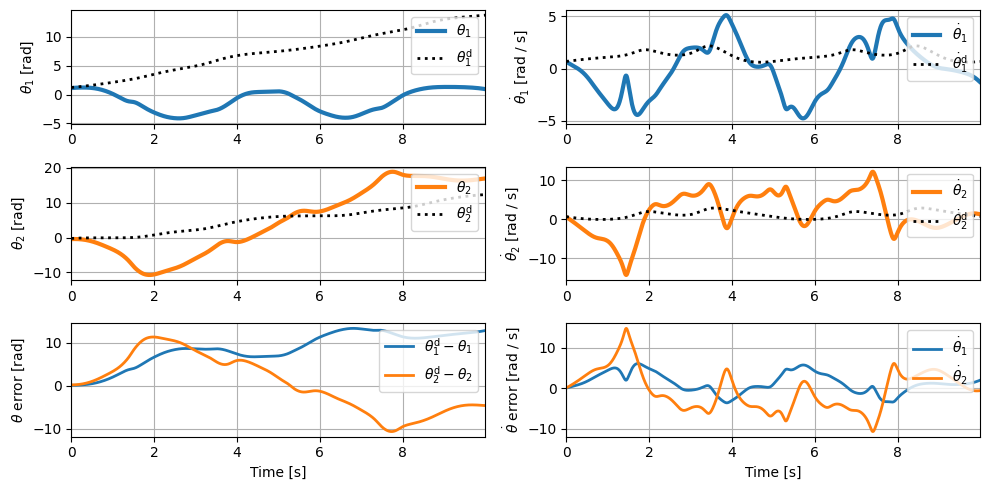

In [7]:
# plot the configuration-space evolution
plot_configuration_space_trajectory_following(
    traj_ts,
    sim_ts_link,
    filepath=str(
        outputs_dir / "task_2a-1-1_configuration_space_trajectory_following.pdf"
    ),
)

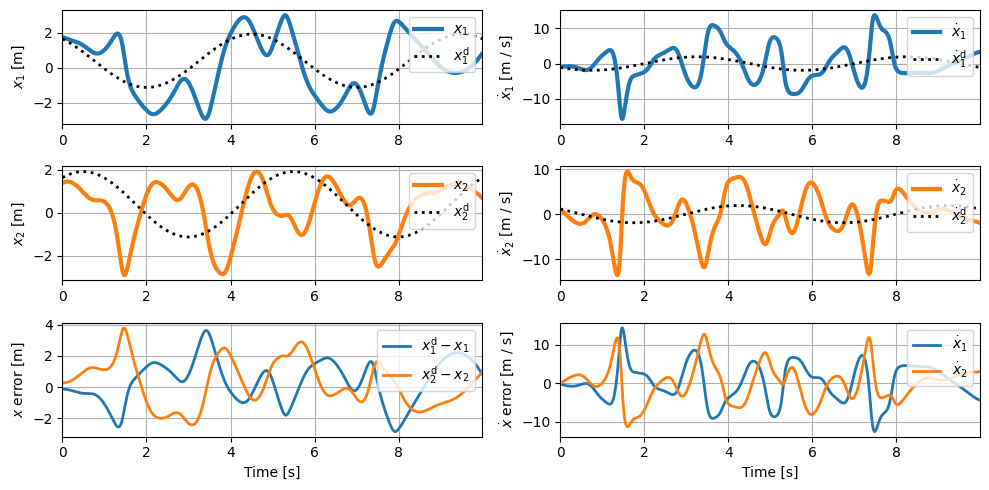

In [8]:
# plot the operational-space evolution
plot_operational_space_trajectory_following(
    traj_ts,
    sim_ts_link,
    filepath=str(
        outputs_dir / "task_2a-1-1_operational_space_trajectory_following.pdf"
    ),
)

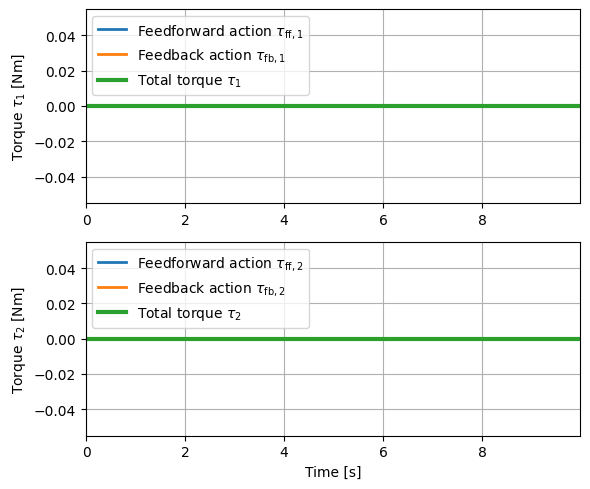

In [9]:
# plot the actuation sequence
plot_actuation(sim_ts_link, filepath=str(outputs_dir / "task_2a-1-1_actuation.pdf"))

In [10]:
print(traj_ts['x_ts'])
print(traj_ts['x_ts'][:, 0].shape)

[[1.63743687 1.63743687]
 [1.62623225 1.64844608]
 [1.614834   1.65925815]
 ...
 [1.66987136 1.6032439 ]
 [1.65925815 1.614834  ]
 [1.64844608 1.62623225]]
(1000,)


MovieWriter ffmpeg unavailable; using Pillow instead.


ValueError: unknown file extension: .mp4

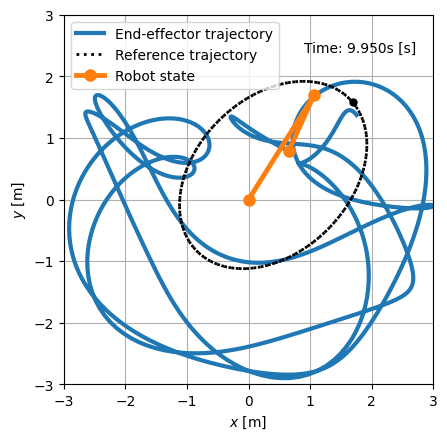

In [11]:
plotting = True
if plotting:
    ani = animate_robot(
        ROBOT_PARAMS,
        traj_ts=traj_ts,
        sim_ts=sim_ts_link,
        step_skip=5,
        show=False,
        filepath=str(outputs_dir / "task_2a-1-1_controlled_robot.mp4"),
    )
    display(HTML(ani.to_html5_video()))